# EC analysis with cellpose

#### This analysis aims to normalise detected signal areas to the number of cells in the slice. To do this, machine learning model 'nuclei' from cellpose is used. It was tested and works pretty well, but:

- the newest version of cellpose (cellpose 4) is no longer compatible the nuclei model and only 'cpasm' model downloads (which should handle everything). The problem is, that this model is too computationally heavy for computers without GPU (like mine). At one point I tested it on one image and it took over 20min (after that I interrupted the kernel as there is no point having script that takes that long). That is the reason why the cellpose this script uses is cellpose2.2.3.

- currently takes about ~1min per image

- has problems with very nuclei-dense areas, but is nonetheless very accurate

- the python version is also Python 3.10.18 (older from the base env.), because it's compatible with the version of cellpose this script uses

#### Tasks:
- *DONE: script creates nuclei masks and saves them into a new folder, downstream analysis pulls on these saved masks (saves time in case of individual image corrections/re-working the script)*

- *DONE: organoid mask is created based on the nuclei mask*
- subepicardium border is a) renamed and b) dependent on the level of gaussian blurring(?)
- *DONE: figure out how to script where to assign the nuclei if they lay on any of the image borders (e.g. if >50% is in epicardium, the nuclei is in epicardium)*
- *DONE: rewrite the script so that it records the area per number of nuclei*
- *DONE(? - area is being recorded in the cell staging script): quality control - size of the nuclei is recorded and the info about average value/error bars is put into the script output*
- *DONE: test of cell cycle staging - since I'm already recording the nuclei, I might as well test if I can identify cell cycle stage distribution in the organoid (secondary script output)*

- **figure out the distances problem** - are the distances mathematical artifact of the script (proliferation would cause the distances to naturally decrease over time)
- make a cutoff distance of ~20um - count the number of ECs that have a macrophage within that distance
- to make the distances more accurate, figure out how to do the surface-to-surface thing... - either Euclidian distance transform, or surface dilation (since I don't need every single object, but only objects within a certain radius of the endothelial cell)

- **add distances and EC analysis into a single script for better accuracy** (no sense having 2 sets of parameters applied to a single image)

- **manage script so that controls could be analysed here without having to use a separate script???**

- add option that if image name contains 5x, 10x, 20x, 40x (etc.) the pixel_size changes accordingly (with 10x likely being the default option)

- DONE: make a new way to record masks

In [1]:
### LIBRARY
import os
import glob
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage.io import imsave
from skimage.color import rgb2gray
from skimage.util import invert
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum, threshold_isodata, threshold_triangle, threshold_mean
from skimage.filters import threshold_otsu, threshold_li, threshold_yen
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_erosion
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_dilation
from skimage.morphology import opening
from scipy.spatial.distance import cdist
from statistics import mean, stdev
import re
from natsort import natsorted
from skimage.color import label2rgb

## cellpose
from cellpose import models
import torch


In [2]:
### PARAMETERS
filename = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/EXP6/Macrophages_and_ECs/ImmEpis_EXP6_d1_GFP_cTnT_CD31'

pixel_size = 0.65

# filename extract
last_folder = os.path.basename(filename)
# output folder:
output_folder = 'C:/Users/terez/Documents/Skola/Ludwig-Maximilians_Universitat_Munchen/Research course Moretti lab/Microscopy data etc/EXP6/EC_analysis'

# to save masks:
folder1 = f'{filename}/masks_with_nuclei_count'
folder2 = f'{filename}/masks_nuclei'
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)

print(last_folder)


ImmEpis_EXP6_d1_GFP_cTnT_CD31


In [4]:
### LOADING IMAGES

## DAPI in 405 channel:
list_of_dapi_files = natsorted(glob.glob(f"{filename}/*ch00*.tif"))
images_dapi = {}
images_dapi_list = []
for file in list_of_dapi_files:
    img = io.imread(file)
    images_dapi[os.path.basename(file)] = img
    images_dapi_list.append(img)

## 488 channel:
list_of_488_files = natsorted(glob.glob(f"{filename}/*ch01*.tif"))
images_488 = {}
for file in list_of_488_files:
    img = io.imread(file)
    images_488[os.path.basename(file)] = img

## 594 channel:
list_of_594_files = natsorted(glob.glob(f"{filename}/*ch02*.tif"))
images_594 = {}
for file in list_of_594_files:
    img = io.imread(file)
    images_594[os.path.basename(file)] = img

## 647 channel:
list_of_647_files = natsorted(glob.glob(f"{filename}/*ch03*.tif"))
images_647 = {}
for file in list_of_647_files:
    img = io.imread(file)
    images_647[os.path.basename(file)] = img

print(f"to check: \n number of 405 images: \t {len(images_dapi)}, \n number of 488 images: \t {len(images_488)},"
      f"\n number of 594 images: \t {len(images_594)}, \n number of 647 images: \t {len(images_647)}")


to check: 
 number of 405 images: 	 15, 
 number of 488 images: 	 15,
 number of 594 images: 	 15, 
 number of 647 images: 	 15


In [5]:
## Grabbing the cellpose masks from the folder

list_of_nuclei_mask_files = natsorted(glob.glob(f"{folder2}/*.tif"))
nuclei_masks = {}

for file in list_of_nuclei_mask_files:
    img = io.imread(file)
    nuclei_masks[os.path.basename(file)] = img


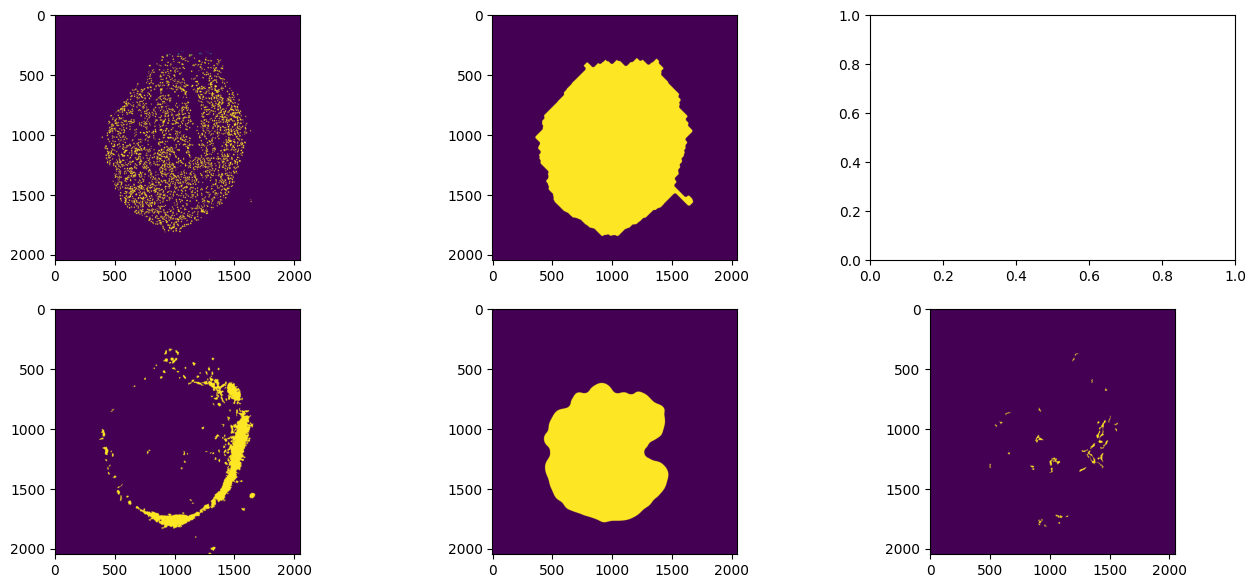

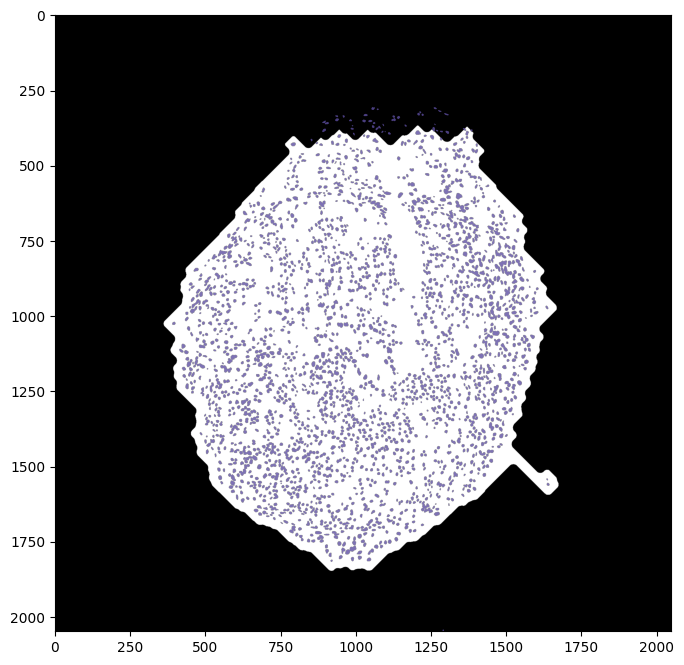

In [28]:
### PARAMETERS testing

tested_image = 'd1_6' #'Image 1'

from skimage.filters import gaussian
from skimage import exposure


## DAPI/organoid area:
# def dapi_analysis(mask, sigma):
#     mask_blurring = gaussian(mask, sigma=sigma) #sigma=25 (usually)
#     thresholding = mask_blurring > threshold_triangle(mask_blurring) #threshold_triangle(mask_blurring)
#     thresholding_2 = remove_small_holes(thresholding, area_threshold=500000)
#     thresholding_3 = remove_small_objects(thresholding_2, min_size=80000) #is this still necessary, since
#                                                                         #I'm using the cellpose mask here...

#     return(thresholding_3)

from skimage.morphology import closing

def dapi_analysis(mask, sigma):
    mask_blurring = gaussian(mask, sigma=5)
    thresholding = mask_blurring > threshold_triangle(mask_blurring)

    dilated = binary_dilation(thresholding, iterations=100)
    closed = closing(dilated, disk(15))
    thresholding_2 = remove_small_holes(closed, area_threshold=500000)
    eroded = binary_erosion(thresholding_2, iterations=80)

    #mask_blurring_2 = gaussian(thresholding, sigma=sigma) #sigma=25 (usually)
    # thresholding_2 = eroded > threshold_triangle(mask_blurring) #threshold_triangle(mask_blurring)
    # thresholding_2 = remove_small_holes(thresholding, area_threshold=500000)
    thresholding_3 = remove_small_objects(eroded, min_size=80000) #is this still necessary, since
                                                                        #I'm using the cellpose mask here...

    return(thresholding_3)


## 488
def analysis_488(image, object_min_size):
    thresholding_1 = image > threshold_triangle(image) #originaly otsu
    thresholding_2 = remove_small_objects(thresholding_1, min_size=object_min_size) #100
    return(thresholding_2)

## 594
def analysis_594(image, sigma):
    background = gaussian(image, sigma=150)   # smooth background
    normalisation = image - background
    normalisation = exposure.rescale_intensity(normalisation, out_range=(0, 1))

    # image_blurring_0 = gaussian(normalisation, sigma=1)
    # thresholding_0 = image_blurring_0 > threshold_li(image_blurring_0) #originally mean
    # thresholding_1 = remove_small_objects(thresholding_0, min_size=100) #originaly 100

    image_blurring = gaussian(normalisation, sigma=sigma) #originaly 15
    thresholding_2 = image_blurring > threshold_li(image_blurring) #originaly li

    closed = closing(thresholding_2, disk(50))

    thresholding_3 = remove_small_holes(closed, area_threshold=800000)
    thresholding_4 = remove_small_objects(thresholding_3, min_size=50000) #800000
    return(thresholding_4)


## 647
def analysis_647(image, object_min_size):
    background = gaussian(image, sigma=50)   # smooth background
    normalisation = image - background 
    normalisation = exposure.rescale_intensity(normalisation, out_range=(0, 1))
    thresholding_1 = normalisation > threshold_triangle(normalisation) # originaly triangle / 470
    thresholding_2 = remove_small_objects(thresholding_1, min_size=object_min_size) #originaly 250
    return(thresholding_2)


### Implementation to actual data:
sigma_dapi = 35
sigma_594 = 28
# add dilation/erosion steps for 405 and 594

object_min_size_488 = 100
object_min_size_647 = 150
dilation_parameter = 30 # number of pixels by which the epicardium is dilated into myocardium
                        # used to be 50... which is maybe a little too big


image_dapi_test = nuclei_masks[f'{tested_image}_ch00_mask.tif'] #_ch00.tif_mask.tif
image_thresholded = dapi_analysis(image_dapi_test,sigma=sigma_dapi)

image_488_test = images_488[f'{tested_image}_ch01.tif']
thresholded_488_test = analysis_488(image_488_test, object_min_size=object_min_size_488)

image_594_test = images_594[f'{tested_image}_ch02.tif']
thresholded_594_2_test = analysis_594(image_594_test,sigma=sigma_594)

image_647_test = images_647[f'{tested_image}_ch03.tif']
thresholded_647_2_test = analysis_647(image_647_test, object_min_size=object_min_size_647)

# # dapi test:
# mask_blur_dapi = gaussian(image_dapi_test, sigma=5) #sigma=25 (usually)

# ## testing of thresholding:
# # tries all automatic thresholding options for the image 
# fig, ax = try_all_threshold(mask_blur_dapi, figsize=(6, 12), verbose=False)
# plt.show()

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,7))
axs[0,0].imshow(image_dapi_test, cmap='viridis', vmin=0, vmax=15)
axs[0,1].imshow(image_thresholded)
axs[1,0].imshow(thresholded_488_test)
axs[1,1].imshow(thresholded_594_2_test)
axs[1,2].imshow(thresholded_647_2_test)


fig, ax = plt.subplots(figsize=(8, 8))

# Show background image
ax.imshow(image_thresholded, cmap='gray')  # Replace with your actual image or mask
# Nuclei
ax.imshow(np.ma.masked_where(image_dapi_test == 0, image_dapi_test), cmap='Spectral', vmin=0, vmax=1, alpha=0.8)


Number of analysed nuclei: 1381


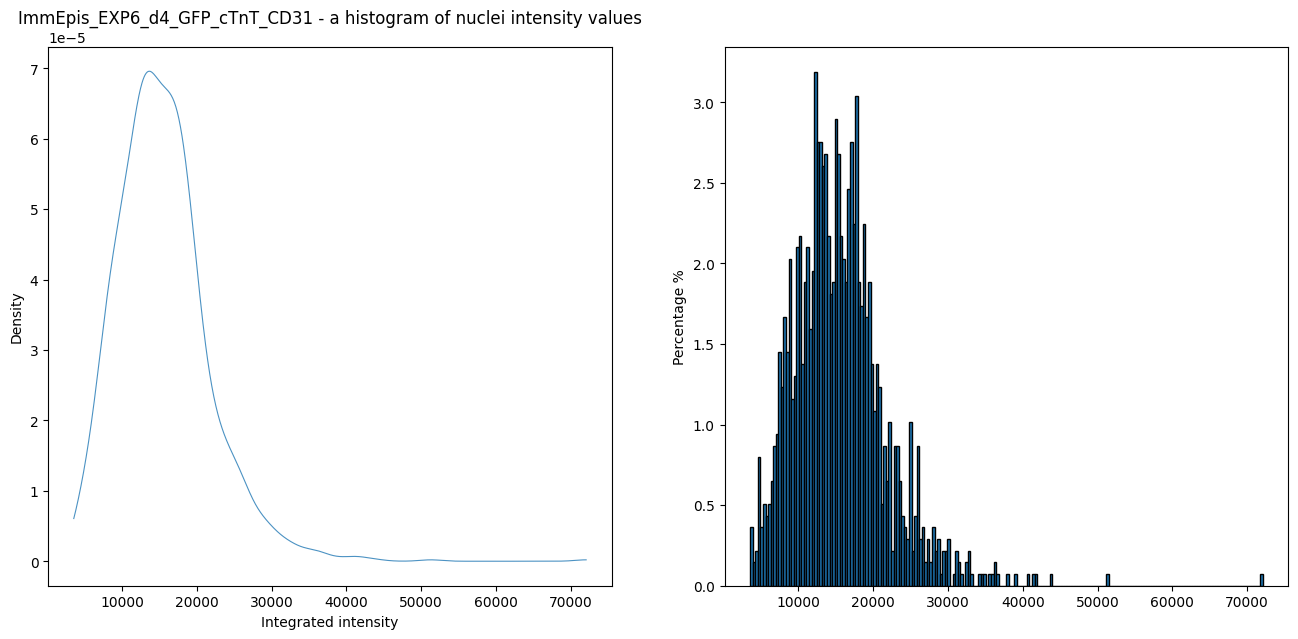

In [12]:
### NUCLEI MASK for cell staging

## current problems:
# - the images were probably taken with different exposure/laser intensity, therefore shouldn't be 
#   grouped together
# - vignetting
# - fluo microscope/not confocal - nuclei in different fields of view are mixing
# - the DAPI stain in the image itself is kinda uneven, could be because of the slice being uneven or 
#   whatever else...

## current solutions
# - analyse the images individually... though that doesn't seem to bring nice results
# - vignetting isn't such a problem, because the organoid is usually in the centre and untouched by the worst
#   of vignetting effect...
# - different FOV are mixing, but considering random distribution it should only introduce noise into the data
#   and not outright skew the results
# - we could pick the best images only... or just keep it in mind for future imaging

from scipy.stats import gaussian_kde


mean_integrated_intensities_per_obj = []
mean_intensity_per_obj = []
area_obj = []

cell_staging = {}

plt.figure(figsize=(18, 12))

for name,img in images_dapi.items():
    name_without_last_part = '_'.join(name.split('_')[:-1])
    objects = regionprops(nuclei_masks[f'{name_without_last_part}_ch00_mask.tif'], img)
    mean_integrated_intensities_per_obj = []
    mean_intensity_per_obj = []
    area_obj = []

    for obj in objects:
        area_obj.append(obj.area)
        integrated_intensity = obj.area * obj.mean_intensity
        mean_integrated_intensities_per_obj.append(integrated_intensity)
        mean_intensity_per_obj.append(obj.mean_intensity)

    cell_staging[name] = {
        'object areas': area_obj,
        'mean integrated intensity per object': mean_integrated_intensities_per_obj,
        'mean intensity per object': mean_intensity_per_obj
    }

    # visualise and save:

    # Fit KDE
    kde = gaussian_kde(mean_integrated_intensities_per_obj)
    x_vals = np.linspace(min(mean_integrated_intensities_per_obj),
                         max(mean_integrated_intensities_per_obj), 1000)
    y_vals = kde(x_vals)

    # Plot as smooth curve
    plt.plot(x_vals, y_vals, label=name, alpha=0.8, linewidth=0.8)

plt.title(f'{last_folder} - a histogram of nuclei intensity values')
plt.xlabel("Integrated intensity")
plt.ylabel("Density")
plt.legend()
## save:
plt.savefig(os.path.join(output_folder, f'{last_folder}_Nuclei_intensity_histogram_KDE.pdf'))
plt.close()


### HISTOGRAM

bins_nb = 200

day = 'Image 2_ch00.tif'

object_areas = cell_staging[day]['object areas']
mi_per_obj = cell_staging[day]['mean intensity per object']
mii_per_obj = cell_staging[day]['mean integrated intensity per object']

# Fit KDE
kde_2 = gaussian_kde(mii_per_obj)
x_vals_2 = np.linspace(min(mii_per_obj),
                     max(mii_per_obj), 1000)
y_vals_2 = kde_2(x_vals_2)



fig, axs = plt.subplots(ncols=2, figsize=(16,7))
# plot curve
axs[0].plot(x_vals_2, y_vals_2, label=day, alpha=0.8, linewidth=0.8)
axs[0].set_xlabel("Integrated intensity")
axs[0].set_ylabel("Density")
axs[0].set_title(f'{last_folder} - a histogram of nuclei intensity values')
# plot histogram
axs[1].hist(mii_per_obj, bins=bins_nb, weights=np.ones(len(mii_per_obj)) / len(mii_per_obj) * 100, edgecolor='black')
axs[1].set_ylabel("Percentage %")

print(f'Number of analysed nuclei: {len(mii_per_obj)}')
## save:
# plt.savefig(os.path.join(output_folder, f'{last_folder}_Nuclei_intensity_histogram.pdf'))


In [ ]:
### Analysis
Image_data_CD31_files = {}

for name,img in images_dapi.items():

    #image name extracted:
    name_without_last_part = '_'.join(name.split('_')[:-1]) # splits the ch__ from the name, so that
                                                              # the script can get the relevant images 
                                                              # from other channels

    ### Creation of masks for the individual channels in the image:   
                                                 
    ## 405 (DAPI)
    mask_405 = nuclei_masks[f'{name_without_last_part}_ch00_mask.tif'] #_ch00.tif_mask.tif
    thresholded_405 = dapi_analysis(mask_405, sigma=sigma_dapi) # organoid mask by blurring nuclei together
    nuclei_objects = regionprops(mask_405, img)
    ## 488 (macs)
    img_488 = images_488[f'{name_without_last_part}_ch01.tif']
    thresholded_488 = analysis_488(img_488, object_min_size=object_min_size_488) & thresholded_405 #only signal overlapping with organoid mask is captured
    ## 594 (cTnT)
    img_594 = images_594[f'{name_without_last_part}_ch02.tif']
    thresholded_594 = analysis_594(img_594, sigma=sigma_594) & thresholded_405
    ## 647 (CD31/CDH5)
    img_647 = images_647[f'{name_without_last_part}_ch03.tif']
    thresholded_647 = analysis_647(img_647, object_min_size=object_min_size_647) & thresholded_405


    ### Calculations:
    
    #DAPI signal/organoid size
    organoid_size = np.sum(thresholded_405) #sum of all pixels, area in pixels^2
    organoid_size_in_um = organoid_size*(pixel_size**2) #area in um^2
    number_of_nuclei = mask_405.max() #number of nuclei detected by cellpose

    # GFP signal/mac area
    overal_488_signal = np.sum(thresholded_488) #sum of all pixels, area in pixels^2

    # 594 signal/cTnT area
    epicardium = thresholded_405 & (~thresholded_594)
    dilated_epicardium = binary_dilation(epicardium, disk(dilation_parameter))
    buffer_zone = thresholded_594 & dilated_epicardium
    #   'buffer zone' is created because a) myocardium is usually slightly overestimated due to the nature
    #   of gaussian blurring, b) both CD31 and macs tend to cluster on the border between myo-epi cardium,
    #   therefore just assigning this region into 'simple' myocardium loses us a lot of information
    buffer_zone_area = np.sum(buffer_zone)
    buffer_zone_area_in_um = buffer_zone_area*(pixel_size**2)

    myocardium = thresholded_594 & (~buffer_zone)
    myocardium_area = np.sum(myocardium)
    myocardium_area_in_um = myocardium_area*(pixel_size**2)
    cTnT_per = myocardium_area/organoid_size

    epicardium_size = np.sum(epicardium)
    epicardium_size_in_um = epicardium_size*(pixel_size**2)
    epicardium_area_per = epicardium_size/organoid_size

    #number of nuclei in myocardium:
    nuclei_count_myo = 0
    nuclei_count_epi = 0
    nuclei_count_buf = 0

    nuclei_sizes = []

    for obj in nuclei_objects:
        coordinates = obj.coords
        nucleus_area = obj.area
        nuclei_sizes.append(nucleus_area)

        # nuclei in myocardium
        overlap_myo = np.sum(myocardium[coordinates[:,0], coordinates[:,1]])
        overlap_myo_per = overlap_myo/nucleus_area
        # nuclei in epicardium
        overlap_epi = np.sum(epicardium[coordinates[:,0], coordinates[:,1]])
        overlap_epi_per = overlap_epi/nucleus_area
        # nuclei at border
        overlap_buffer = np.sum(buffer_zone[coordinates[:,0], coordinates[:,1]])
        overlap_buff_per = overlap_buffer/nucleus_area

        if overlap_myo_per > 0.5:
            nuclei_count_myo += 1

        if overlap_epi_per > 0.5:
            nuclei_count_epi += 1

        if overlap_buff_per > 0.5:
            nuclei_count_buf += 1

    if nuclei_count_epi ==0:
        print(f"There is no epicardium in: {name_without_last_part}")


    # 647 signal/CD31 area
    overal_647_signal = np.sum(thresholded_647)


    # for analysis:
    CD31_area = overal_647_signal/organoid_size
    CD31_area_per_nuclei = overal_647_signal/number_of_nuclei

    macs_area = overal_488_signal/organoid_size
    macs_area_per_nuclei = overal_488_signal/number_of_nuclei
    
    ## are CD31+ in epicardium or myocardium?

    # area of signal per number of nuclei in epi/myo/buf
    CD31_in_epi = np.sum(thresholded_647 & epicardium)*(pixel_size**2)
    CD31_in_epi_per_nuclei = CD31_in_epi/nuclei_count_epi
    CD31_in_myo = np.sum(thresholded_647 & myocardium)*(pixel_size**2)
    CD31_in_myo_per_nuclei = CD31_in_myo/nuclei_count_myo
    CD31_in_buf = np.sum(thresholded_647 & buffer_zone)*(pixel_size**2)
    CD31_in_buf_per_nuclei = CD31_in_buf/nuclei_count_buf

    GFP_in_epi = np.sum(thresholded_488 & epicardium)*(pixel_size**2)
    GFP_in_epi_per_nuclei = GFP_in_epi/nuclei_count_epi
    GFP_in_myo = np.sum(thresholded_488 & myocardium)*(pixel_size**2)
    GFP_in_myo_per_nuclei = GFP_in_myo/nuclei_count_myo
    GFP_in_buf = np.sum(thresholded_488 & buffer_zone)*(pixel_size**2)
    GFP_in_buf_per_nuclei = GFP_in_buf/nuclei_count_buf

    # area per organoid area
    CD31_in_buffer_sum = np.sum(CD31_in_buf)
    CD31_in_buffer_per = CD31_in_buffer_sum/overal_647_signal

    # CD31 in myocardium:
    CD31_in_cTnT = np.sum(CD31_in_myo)
    CD31_per_in_cTnT = CD31_in_cTnT/overal_647_signal
    
    # CD31 in epicardium
    CD31_in_epicardium = np.sum(CD31_in_epi)
    CD31_per_in_epicardium = CD31_in_epicardium/overal_647_signal

    ## are GFP+ in epicardium or myocardium?

    # GFP in buffer zone
    GFP_in_buffer = np.sum(GFP_in_buf)
    GFP_in_buffer_per = GFP_in_buffer/overal_488_signal

    # GFP in myocardium:
    GFP_in_cTnT = np.sum(GFP_in_myo)
    GFP_per_in_cTnT = GFP_in_cTnT/overal_488_signal
    
    # GFP in epicardium
    GFP_in_epicardium = np.sum(GFP_in_epi)
    GFP_per_in_epicardium = GFP_in_epicardium/overal_488_signal

    # image mask:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Show background image
    ax.imshow(thresholded_405, cmap='gray')
    # Overlay cTnT in magenta
    ax.imshow(np.ma.masked_where(myocardium == 0, myocardium), cmap='magma', alpha=0.4)
    # Overlay buffer
    ax.imshow(np.ma.masked_where(buffer_zone == 0, buffer_zone), cmap='gray', alpha=0.3)
    # Overlay macrophages in green
    ax.imshow(np.ma.masked_where(thresholded_488 == 0, thresholded_488), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
    # Overlay CD31 in red
    ax.imshow(np.ma.masked_where(thresholded_647 == 0, thresholded_647), cmap='autumn', alpha=0.8)
    # Nuclei
    ax.imshow(np.ma.masked_where(mask_405 == 0, mask_405), cmap='Blues', vmin=0, vmax=1, alpha=0.8)

    ax.set_title(f"Channel masks for image: {name_without_last_part}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{folder1}/{name_without_last_part}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

    # image data
    Image_data_CD31_files[name_without_last_part] = {
        'organoid area': organoid_size,
        'organoid area in um': organoid_size_in_um,
        'number of nuclei': number_of_nuclei,
        'average nuclei size': mean(nuclei_sizes),
        'nuclei sizes stdev': stdev(nuclei_sizes),
        'myocardium area': myocardium_area,
        'myocardium area in um': myocardium_area_in_um,
        'myocardium area per': cTnT_per,
        'myocardium nuclei': nuclei_count_myo,
        'myocardium nuclei per': nuclei_count_myo/number_of_nuclei,
        'epicardium area': epicardium_size,
        'epicardium area in um': epicardium_size_in_um,
        'epicardium area per': epicardium_area_per,
        'epicardium nuceli': nuclei_count_epi,
        'epicardium nuclei per': nuclei_count_epi/number_of_nuclei,
        'buffer zone nuclei': nuclei_count_buf,
        'buffer nuclei per': nuclei_count_buf/number_of_nuclei,
        'epi+buf nuclei': nuclei_count_buf + nuclei_count_epi,
        'epi+buf nuclei per': nuclei_count_epi/number_of_nuclei + nuclei_count_buf + nuclei_count_epi,
        'CD31 area': CD31_area,
        'GFP area': macs_area,
        'macs in epicardium per': GFP_per_in_epicardium,
        'macs in myocardium per': GFP_per_in_cTnT,
        'macs in buffer zone per': GFP_in_buffer_per,
        'macs in epi+buf per': GFP_per_in_epicardium + GFP_in_buffer_per,
        'CD31 in epicardium per': CD31_per_in_epicardium,
        'CD31 in myocardium per': CD31_per_in_cTnT,
        'CD31 in buffer zone per': CD31_in_buffer_per,
        'CD31 in epi+buf per':CD31_per_in_epicardium + CD31_in_buffer_per,
        'CD31 per nucleus count': CD31_area_per_nuclei,
        'macs per nucleus count': macs_area_per_nuclei,
        'CD31 in epi per nuclei': CD31_in_epi_per_nuclei,
        'CD31 in buf per nuclei': CD31_in_buf_per_nuclei,
        'CD31 in myo per nuclei': CD31_in_myo_per_nuclei,
        'macs in epi per nuclei': GFP_in_epi_per_nuclei,
        'macs in buf per nuclei': GFP_in_buf_per_nuclei,
        'macs in myo per nuclei': GFP_in_myo_per_nuclei

    }

#NOTE: the CD31 channel has a ton of specks (mainly for EXP7), that are clearly not a real signal, 
#      which I removed using 'remove small objects' function. It could get rid of some of the 
#      signal as well...

#NOTE: I could also try to count the number of macrophages by counting the number of nuclei present in
#      the signal. But it's a fluorescent image, not confocal and the nuclei can be from cardiomyocytes

#NOTE: subtract the mean background intensity when calculating mean intensity of cells. This would result
#      more information metric to judge the quality of segmentation...


In [14]:
### DATAFRAME
df_stain1 = pd.DataFrame.from_dict(Image_data_CD31_files, orient='index')

output_path = f'{output_folder}/{last_folder}.xlsx'
df_stain1.to_excel(output_path)

## NOTE to self: epicardium size - overal CD31 area correlation?
